<a href="https://colab.research.google.com/github/danwein8/Deep-Q-Network-Agents/blob/main/SpaceInvaders4DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

if COLAB:
  !sudo apt-get install -y xvfb ffmpeg
  !pip install -q ale-py
  !pip install -q 'gym==0.17.3'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q --upgrade tensorflow-probability
  !pip install -q 'tf-agents==0.12.0'

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.3.2 which is incompatible.


In [17]:
# Heaton Imports
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

# Checkpoint imports
import io
import os
import shutil
import tempfile
import zipfile
from tf_agents.policies import policy_saver
try:
  from google.colab import files
except ImportError:
  files = None

# Atari Preprocessing Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Heaton Imports
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.environments import batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# Atari Preprocessing Imports
from gym import core as gym_core
from tf_agents.environments import atari_preprocessing as preprocessing

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()



In [18]:
# HYPERPARAMATERS
# number of times we will run the training
num_iterations = 150000

# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 10000
# the amount of steps we collect each episode to add to the buffer OR
# How many steps should we run each iteration to collect
# data from.
collect_steps_per_iteration = 10
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 32
learning_rate = 2.5e-3
# How often should the program provide an update.
log_interval = 5000

# How many episodes should the program use for each evaluation.
num_eval_episodes = 10
# How often should an evaluation occur.
eval_interval = 25000


In [19]:
!pip install gym[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# HIDE OUTPUT
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e -o+ /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

Streaming output truncated to the last 5000 lines.
Extracting  /content/ROM/3D Tic-Tac-Toe (32 in 1) (1988) (Atari, Carol Shaw) (CX26163P) (PAL).bin       1%  OK 
Extracting  /content/ROM/4 Game in One - Ice Hockey, Phantom UFO, Spy Vs. Spy, Cosmic Avenger (1983) (Bit Corporation) (PAL).bin       1%  OK 
Extracting  /content/ROM/4 Game in One - Rodeo Champ, Open Sesame, Bobby Is Going Home, Festival (1983) (Bit Corporation) (P460) (PAL).bin       1%  OK 
Extracting  /content/ROM/4 in 1 - Canyon Bomber, Home Run, Night Driver, Sky Diver (02-19-1987) (Atari) (CX26137) (Prototype).bin       1%  OK 
Extracting  /content/ROM/8 in 1 (Supergames 8 in 1) (01-16-92) (Atari) (CX26193) (Prototype).bin       1%  OK 
Extracting  /content/ROM/========  ROM HUNTER'S 1977-1992 VCS ROMS COLLECTION V18  ========.txt       1%  OK 
Extracting  /content/ROM/A-Team, The (AKA Saboteur) (03-30-1984) (Atari, Jerome Domurat, Howard Scott Warshaw) (CX26133) (

In [21]:
# environment name
env_name = 'SpaceInvaders-v4'
# render skip inherent to Atari games that causes massive confusion for the agent
# so we take this into consideration by using a preprocessing wrapper for every
# 4 frames, giving us solid info for our policy.
# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4

max_episode_frames=108000  # ALE frames

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
#env = batched_py_environment.BatchedPyEnvironment([env])

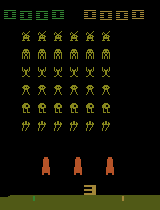

In [22]:
env.reset()
PIL.Image.fromarray(env.render())


In [23]:
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [24]:
# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4


class AtariCategoricalQNetwork(network.Network):
    """CategoricalQNetwork subclass that divides observations by 255."""

    def __init__(self, input_tensor_spec, action_spec, **kwargs):
        super(AtariCategoricalQNetwork, self).__init__(
            input_tensor_spec, state_spec=())
        input_tensor_spec = tf.TensorSpec(
            dtype=tf.float32, shape=input_tensor_spec.shape)
        self._categorical_q_network = \
            categorical_q_network.CategoricalQNetwork(
                input_tensor_spec, action_spec, **kwargs)

    @property
    def num_atoms(self):
        return self._categorical_q_network.num_atoms

    def call(self, observation, step_type=None, network_state=()):
        state = tf.cast(observation, tf.float32)
        # We divide the grayscale pixel values by 255 here rather than
        # storing normalized values beause uint8s are 4x cheaper to
        # store than float32s.
        # TODO(b/129805821): handle the division by 255 for
        # train_eval_atari.py in
        # a preprocessing layer instead.
        state = state / 255
        return self._categorical_q_network(
            state, step_type=step_type, network_state=network_state)

In [25]:
# HYPERPARAMETERS
# Fully connected layers (dense)
fc_layer_params = (512,)
# convolutional layers ((channels, (input, input), stride), ...)
conv_layer_params = ((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

q_net = AtariCategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


In [26]:
"""optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.95,
    momentum=0.0,
    epsilon=0.00001,
    centered=True)"""
"""
learn_rate=1e-3
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learn_rate)
    """
optimizer = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=learning_rate,
    rho=0.95,
    epsilon=0.00001
)

train_step_counter = tf.Variable(0)

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.from_spec(train_env.action_spec())
target_update_period = 32000  # ALE frames
update_period = 16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP


agent = categorical_dqn_agent.CategoricalDqnAgent(
    time_step_spec,
    action_spec,
    categorical_q_network=q_net,
    optimizer=optimizer,
    min_q_value=-10,
    max_q_value=10,
    #epsilon_greedy=epsilon,
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False)

agent.initialize()


In [27]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of
# different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [28]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


In [29]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step,\
                                      next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer,
             steps=initial_collect_steps)

In [30]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy,
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and 
    # save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and 
    # update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy,
                                        num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


step = 5000: loss = 3.809069871902466
step = 10000: loss = 3.4651689529418945
step = 15000: loss = 3.2815661430358887
step = 20000: loss = 2.7470083236694336
step = 25000: loss = 2.9515514373779297
step = 25000: Average Return = 235.5
step = 30000: loss = 2.523836374282837
step = 35000: loss = 2.8132410049438477
step = 40000: loss = 2.4320015907287598
step = 45000: loss = 2.3604049682617188
step = 50000: loss = 2.0673089027404785
step = 50000: Average Return = 242.0
step = 55000: loss = 2.199892520904541
step = 60000: loss = 1.8667590618133545
step = 65000: loss = 1.798297643661499
step = 70000: loss = 1.7219212055206299
step = 75000: loss = 1.804593801498413
step = 75000: Average Return = 381.5
step = 80000: loss = 1.7438969612121582
step = 85000: loss = 1.7401667833328247
step = 90000: loss = 1.6934058666229248
step = 95000: loss = 1.6796324253082275
step = 100000: loss = 1.8037869930267334
step = 100000: Average Return = 286.5
step = 105000: loss = 1.5349125862121582
step = 110000: 

In [31]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


In [32]:
# HIDE OUTPUT
create_policy_eval_video(agent.policy, "trained-agent")


In [47]:
# HIDE OUTPUT
create_policy_eval_video(random_policy, "random-agent")

In [61]:
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [62]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

In [63]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [64]:
tf_policy_saver.save(policy_dir)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


(111.65, 500.0)

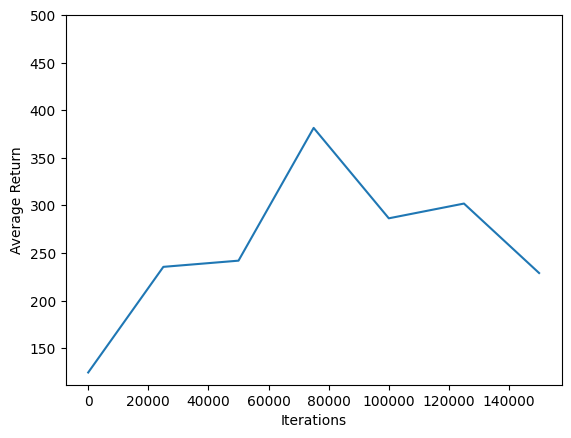

In [65]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=500)

In [66]:
#@title Create zip file and upload zip file (double-click to see the code)
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

In [67]:
train_checkpointer.save(train_step_counter)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

In [ ]:
if files is not None:
  files.download(checkpoint_zip_filename)

In [ ]:
files.download(checkpoint_zip_filename)

In [70]:
shutil.copy('/tmp/exported_cp.zip', '/content/drive/MyDrive/Colab Notebooks')

'/content/drive/MyDrive/Colab Notebooks/exported_cp.zip'

In [107]:
train_checkpointer.initialize_or_restore()
train_step_counter = tf.compat.v1.train.get_global_step()

In [108]:
num_iterations = 10000
log_interval = 1000
initial_collect_steps = 0
collect_steps_per_iteration = 5

# How often should an evaluation occur.
eval_interval = 2500

In [109]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy,
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and 
    # save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and 
    # update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy,
                                        num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 1000: loss = 1.6275361776351929
step = 2000: loss = 1.3611136674880981
step = 2500: Average Return = 270.0
step = 3000: loss = 1.513774037361145
step = 4000: loss = 1.7442505359649658
step = 5000: loss = 1.633449912071228
step = 5000: Average Return = 252.5
step = 6000: loss = 1.2695176601409912
step = 7000: loss = 1.6272358894348145
step = 7500: Average Return = 352.0


KeyboardInterrupt: ignored

In [110]:
# HIDE OUTPUT
create_policy_eval_video(agent.policy, "trained-agent")

In [111]:
train_checkpointer.save(train_step_counter)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

In [112]:
shutil.copy('/tmp/exported_cp.zip', '/content/drive/MyDrive/Colab Notebooks')

'/content/drive/MyDrive/Colab Notebooks/exported_cp.zip'